In [5]:
# IMPORTS AND OTHER SETTINGS
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels

from statsmodels.tsa.stattools import adfuller
from pandas.plotting import register_matplotlib_converters
from pathlib import Path
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import lag_plot
from pmdarima import auto_arima
from math import sqrt
from sklearn.metrics import mean_squared_error

register_matplotlib_converters()

In [15]:
# Read csv file from disk, download and localize it if not already there
filename = 'median_transaction_confirmation_time.csv'
config = Path(filename)
if config.is_file():
    print(f'CSV file already exists in this directory, skipping download.\n\nFirst 5 lines of loaded df:')
    df = pd.read_csv(filename, parse_dates=['date'], index_col='date')
    print(df.head())
else:
    url = 'https://api.blockchain.info/charts/median-confirmation-time?timespan=1years&format=csv'
#     url = 'https://api.blockchain.info/charts/median-confirmation-time?timespan=8years&daysAverageString=7&format=csv'
    print(f'CSV file not found, downloading and writing to current directory.\n\nFirst 5 lines of loaded df:')
    df = pd.read_csv(url, names=['date', 'value'], parse_dates=['date'], index_col='date')
    df.to_csv(filename, sep=',', encoding='utf-8', index='date')
    print(df.head())
    print('Reading CSV back from disk:\n\nFirst 5 lines of loaded df:')
    df = pd.read_csv(filename, parse_dates=['date'], index_col='date')
    print(df.head())

CSV file not found, downloading and writing to current directory.

First 5 lines of loaded df:
                value
date                 
2018-12-06  10.233333
2018-12-07  12.300000
2018-12-08   9.633333
2018-12-09   9.166667
2018-12-10  10.566667
Reading CSV back from disk:

First 5 lines of loaded df:
                value
date                 
2018-12-06  10.233333
2018-12-07  12.300000
2018-12-08   9.633333
2018-12-09   9.166667
2018-12-10  10.566667


In [14]:
# Calculate basic statistics for the data (Mean/Variance)
mean = np.mean(df.value)
var = np.var(df.value)

print('Summary Statistics:\n')
print(f'\tMean:\t\t{mean:0.2f}\n')
print(f'\tVariance:\t{var:0.2f}')

Summary Statistics:

	Mean:		9.24

	Variance:	1.05


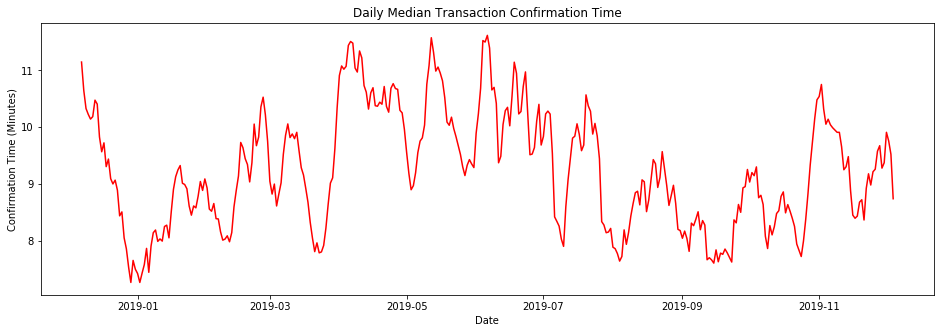

In [8]:
# Plot overall DF
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(16, 5)
ax.plot(df.index, df.value, color='red')
ax.set_title('Daily Median Transaction Confirmation Time')
ax.set_ylabel('Confirmation Time (Minutes)')
ax.set_xlabel('Date')
plt.show()

In [9]:
# Check stationarity of the data
def clean_df_vals(df):
    tmp = []
    for val in df.values:
        tmp.append(val[0])
    return tmp

result = adfuller(clean_df_vals(df))
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.479524
p-value: 0.120536
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


Text(0.5, 104.99999999999989, 'Time')

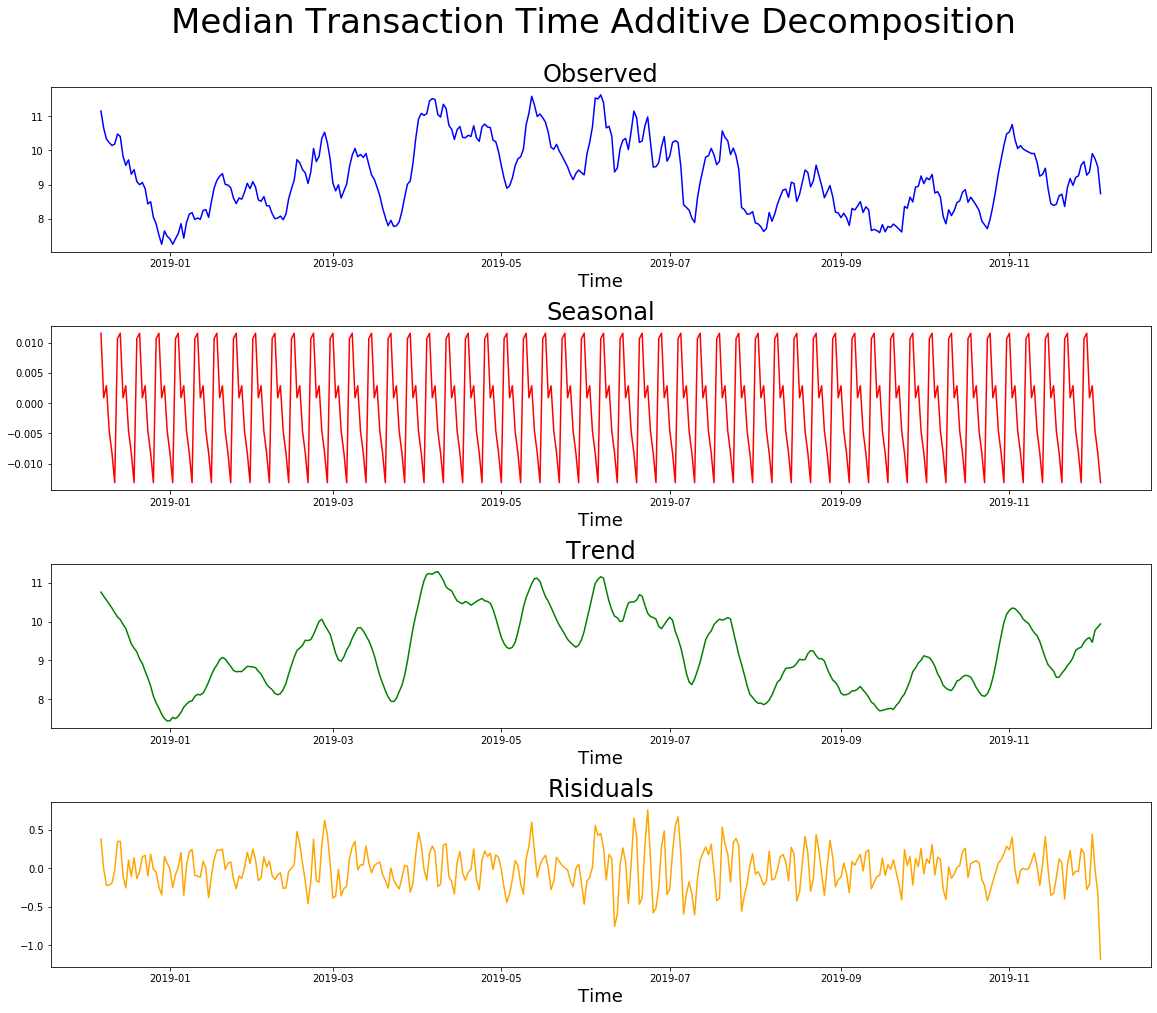

In [10]:
# Additive decomposition
add_decomp = seasonal_decompose(df.value, model='additive', extrapolate_trend='freq')


fig, ax = plt.subplots(4, 1, figsize=(16, 14))
fig.suptitle('Median Transaction Time Additive Decomposition', fontsize=34)
fig.tight_layout()
fig.subplots_adjust(hspace=0.45, top = 0.9)


ax[0].plot(add_decomp.observed, color='blue')
ax[0].set_title('Observed', fontsize=24)
ax[0].set_xlabel('Time', fontsize=18)


ax[1].plot(add_decomp.seasonal, color='red')
ax[1].set_title('Seasonal', fontsize=24)
ax[1].set_xlabel('Time', fontsize=18)

ax[2].plot(add_decomp.trend, color='green')
ax[2].set_title('Trend', fontsize=24)
ax[2].set_xlabel('Time', fontsize=18)

ax[3].plot(add_decomp.resid, color='orange')
ax[3].set_title('Risiduals', fontsize=24)
ax[3].set_xlabel('Time', fontsize=18)

Text(0.5, 1.0, 'Partial Autocorrelation Function')

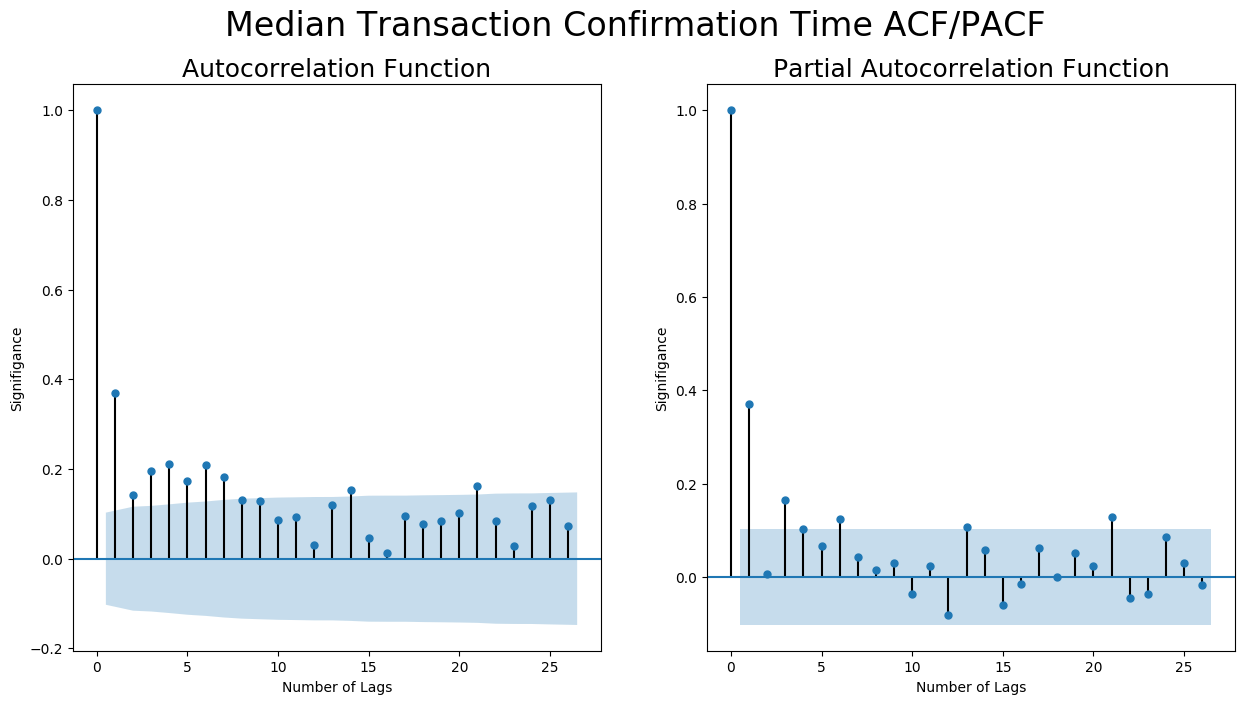

In [16]:
# ACF and PACF
fig, ax = plt.subplots(1, 2, figsize=(15,7.5), dpi = 100)
fig.suptitle('Median Transaction Confirmation Time ACF/PACF', fontsize=24)

plot_acf(df.value, ax=ax[0])
plot_pacf(df.value, ax=ax[1])

ax[0].set_xlabel('Number of Lags')
ax[0].set_ylabel('Signifigance')
ax[0].set_title("Autocorrelation Function", fontsize=18)

ax[1].set_xlabel('Number of Lags')
ax[1].set_ylabel('Signifigance')
ax[1].set_title("Partial Autocorrelation Function", fontsize=18)



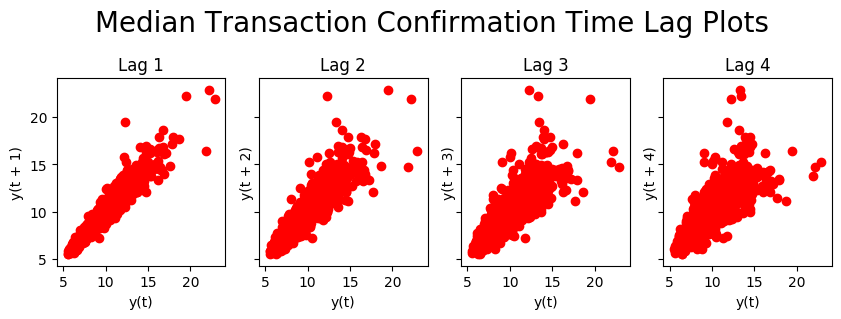

In [12]:
# Lag Plots
fig, ax = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
fig.suptitle('Median Transaction Confirmation Time Lag Plots', fontsize=20)
fig.subplots_adjust(hspace=0.45, top = 0.75)


for i, ax_local in enumerate(ax.flatten()[:4]):
    lag_plot(df.value, lag=i+1, ax=ax_local, c='red')
    ax_local.set_title(f'Lag {i+1}')


In [13]:
# Arima Model
model_aarima = auto_arima(df, suppress_warnings=True)
print(model_aarima.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 1460
Model:               SARIMAX(3, 1, 4)   Log Likelihood               -1291.531
Date:                Thu, 05 Dec 2019   AIC                           2601.063
Time:                        17:32:34   BIC                           2648.632
Sample:                             0   HQIC                          2618.809
                               - 1460                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0019      0.006     -0.341      0.733      -0.013       0.009
ar.L1          0.1709      0.081      2.112      0.035       0.012       0.330
ar.L2         -0.0474      0.071     -0.671      0.5

In [14]:
# Holt Winter Model
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

model_hw = Holt(df).fit()
print(model_hw.summary())

                              Holt Model Results                              
Dep. Variable:                  endog   No. Observations:                 1460
Model:                           Holt   SSE                            617.577
Optimized:                       True   AIC                          -1248.166
Trend:                       Additive   BIC                          -1227.021
Seasonal:                        None   AICC                         -1248.108
Seasonal Periods:                None   Date:                 Thu, 05 Dec 2019
Box-Cox:                        False   Time:                         17:34:14
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            1.0000000                alpha                 True
smoothing_slope             0.000000                

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency 2D will be used.
  % freq, ValueWarning)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency 2D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency 2D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                 1094
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -1073.304
Method:                       css-mle   S.D. of innovations              0.645
Date:                Thu, 05 Dec 2019   AIC                           2156.608
Time:                        17:34:59   BIC                           2181.596
Sample:                    12-10-2011   HQIC                          2166.064
                         - 12-04-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0001      0.007      0.019      0.985      -0.013       0.013
ar.L1.D.value     0.7909      0.034     23.596      0.000       0.725       0.857
ma.L1.D.value    -0.6848      0.037    -

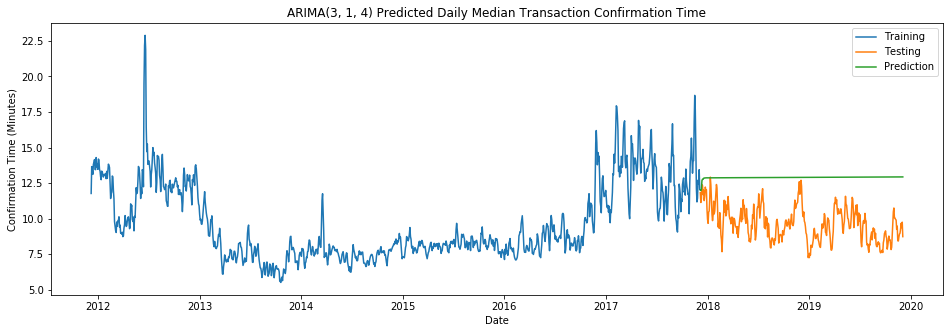

AIC:	2015.6006933059082
BIC:	2060.5790571527455
RMSE:	3.4357013939599907


In [15]:
# Split the data
data_arima_training = df.head(round(0.75 * len(df)))
data_arima_testing = df.tail(len(df)-len(data_arima_training))

# Arima Model creation and 
model_aarima = auto_arima(data_arima_training, error_action='ignore', suppress_warnings=True)
from statsmodels.tsa.arima_model import ARIMA
model_arima = ARIMA(data_arima_training, order=(1, 1, 2))
model_arima_fit = model_arima.fit(disp=0)
model_aarima.fit(data_arima_training)

print(model_arima_fit.summary())
print(model_aarima.summary())
arima_forecast = model_aarima.predict(n_periods = len(data_arima_testing))
arima_forecast = pd.DataFrame(arima_forecast, index=data_arima_testing.index)

# Plot overall DF
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(16, 5)
# ax.plot(df.index, df.value, color='red')
ax.plot(data_arima_training, label='Training')
ax.plot(data_arima_testing, label='Testing')
ax.plot(arima_forecast, label='Prediction')
ax.set_title(f'ARIMA{model_aarima.order} Predicted Daily Median Transaction Confirmation Time')
ax.set_ylabel('Confirmation Time (Minutes)')
ax.set_xlabel('Date')
ax.set_facecolor('white')
ax.legend()
plt.show()

arima_rms = sqrt(mean_squared_error(data_arima_testing, arima_forecast))

print(f'AIC:\t{model_aarima.aic()}')
print(f'BIC:\t{model_aarima.bic()}')
print(f'RMSE:\t{arima_rms}')


1095 365
2017-12-06    12.062168
2017-12-08    12.062431
2017-12-10    12.062695
2017-12-12    12.062958
2017-12-14    12.063222
                ...    
2019-11-26    12.156976
2019-11-28    12.157239
2019-11-30    12.157503
2019-12-02    12.157766
2019-12-04    12.158029
Freq: 2D, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency 2D will be used.
  % freq, ValueWarning)


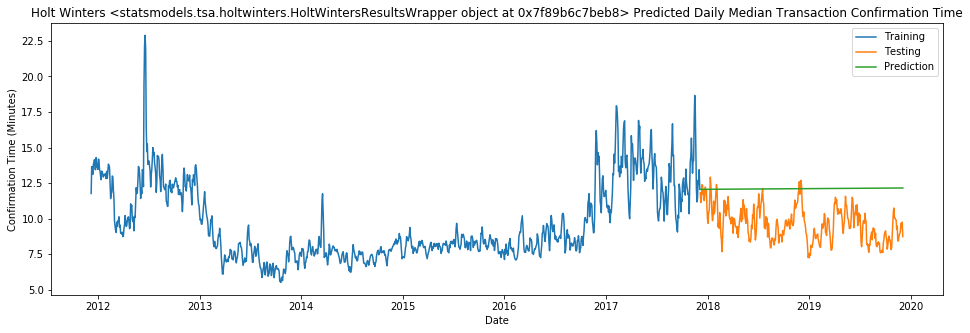

AIC:	-845.9363676094507
BIC:	-825.9423290404483


In [16]:
# Split the data
from statsmodels.tsa.holtwinters import Holt

data_hw_training = df.head(round(0.75 * len(df)))
data_hw_testing = df.tail(len(df)-len(data_hw_training))
print(len(data_hw_training), len(data_hw_testing))
# Holt Winter Model
hw_model_fit = Holt(data_hw_training).fit(optimized=True)
hw_forecast = hw_model_fit.forecast(len(data_hw_testing))

print(hw_forecast)
# Plot overall DF
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(16, 5)
# ax.plot(df.index, df.value, color='red')
ax.plot(data_hw_training, label='Training')
ax.plot(data_hw_testing, label='Testing')
ax.plot(hw_forecast, label='Prediction')
ax.set_title(f'Holt Winters {hw_model_fit} Predicted Daily Median Transaction Confirmation Time')
ax.set_ylabel('Confirmation Time (Minutes)')
ax.set_xlabel('Date')
ax.legend()
plt.show()

# rms = sqrt(mean_squared_error(data_hw_testing, forecast))

print(f'AIC:\t{hw_model_fit.aic}')
print(f'BIC:\t{hw_model_fit.bic}')
# print(f'RMSE:\t{rms}')

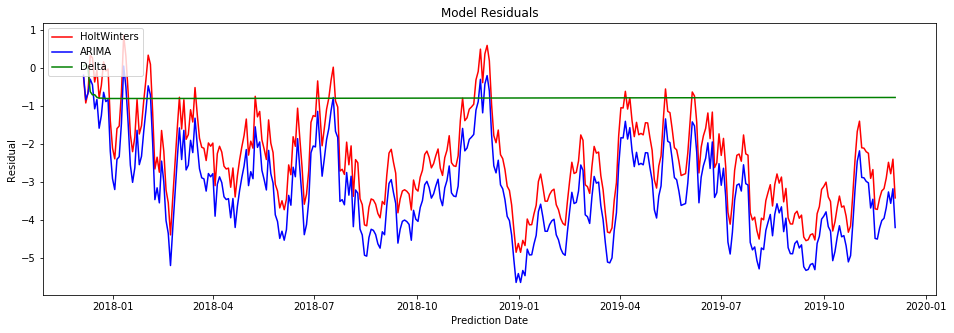

In [17]:
# Risiduals

arima_residuals = pd.DataFrame(0.0, index=data_arima_testing.index, columns=list('v'))
hw_residuals = pd.DataFrame(0.0, index=data_hw_testing.index, columns=list('v'))
delta_residuals = pd.DataFrame(0.0, index=data_hw_testing.index, columns=list('v'))

for i in range(len(arima_residuals)):
    arima_residuals['v'][i] = data_arima_testing['value'][i] - arima_forecast[0][i]
    hw_residuals['v'][i] = data_hw_testing['value'][i] - hw_forecast[i]
    delta_residuals['v'][i] = arima_residuals['v'][i] - hw_residuals['v'][i]
    
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(16, 5)
ax.set_title('Model Residuals')
ax.plot(hw_residuals, color='red', label='HoltWinters', alpha=1)
ax.plot(arima_residuals, color='blue', label='ARIMA', alpha=1)
ax.plot(delta_residuals, color='green', label='Delta')
ax.set_ylabel('Residual')
ax.set_xlabel('Prediction Date')
ax.legend(loc='upper left')
plt.show()